In [115]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ML
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Read data
weather = pd.read_csv("daily-weather.csv")
solar = pd.read_csv("solar-output_daily.csv")

In [5]:
weather['Date'] = pd.to_datetime(weather['Date']).dt.date
solar['Timestamp'] = pd.to_datetime(solar['Timestamp']).dt.date

In [38]:
df = pd.merge(weather, solar, left_on='Date', right_on='Timestamp')
df = df.reset_index(drop=True)
df.drop(columns=['Timestamp', 'New Nexus 1272 Meter', 'Inverters'], inplace=True)
df

,Date,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy,Site Performance Estimate
0,2016-02-01,0.10,9.45,3.11,0.32,79.46,4.70,29.23,30.02,20256.0,19043
1,2016-02-02,0.80,3.94,6.99,6.22,93.60,13.29,28.91,29.70,1761.0,19170
2,2016-02-03,0.87,8.70,1.62,0.02,85.00,16.73,29.03,29.82,2775.0,19298
3,2016-02-04,0.37,10.00,-2.47,-5.89,74.52,9.46,29.46,30.26,28695.0,19425
4,2016-02-05,0.52,9.21,-2.00,-4.15,82.03,5.92,29.55,30.35,9517.0,19553
...,...,...,...,...,...,...,...,...,...,...,...
632,2017-10-25,0.23,10.00,5.87,2.89,82.33,5.56,29.04,29.83,13737.0,19703
633,2017-10-26,0.01,10.00,10.59,5.32,72.74,9.61,28.97,29.76,27465.0,19484
634,2017-10-27,0.89,10.00,5.79,0.04,67.37,13.62,29.08,29.87,15797.0,19264
635,2017-10-28,0.99,9.67,3.43,-0.11,77.87,9.67,29.15,29.94,6400.0,19045


In [16]:
df.to_csv("joined-weather-solar.csv")

In [40]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)
# # Visualize the data
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Temperature'], marker='o', linestyle='-', color='b')
plt.title('Temperature (2016 - 2017)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Site Performance Estimate'], marker='o', linestyle='-', color='b')
plt.title('Solar Energy Production (2016 - 2017)')
plt.xlabel('Date')
plt.ylabel('kW')

Text(0, 0.5, 'kW')

### Linear Regression

In [45]:
# Define features (x) and the target variable (y)
x = df.drop(columns='Site Performance Estimate')
y = df['Site Performance Estimate']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit linear regression
regression = sm.OLS(y_train, x_train)
results = regression.fit()
y_pred = results.predict(x_test)

r2_score(y_test, y_pred)
print(results.summary())

                                    OLS Regression Results                                    
Dep. Variable:     Site Performance Estimate   R-squared (uncentered):                   0.985
Model:                                   OLS   Adj. R-squared (uncentered):              0.985
Method:                        Least Squares   F-statistic:                              3765.
Date:                       Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                               13:23:57   Log-Likelihood:                         -4809.1
No. Observations:                        509   AIC:                                      9636.
Df Residuals:                            500   BIC:                                      9674.
Df Model:                                  9                                                  
Covariance Type:                   nonrobust                                                  
                        coef    std err          t

In [48]:
conf_int = results.conf_int()

# Filter features based on confidence intervals
not_significant = (conf_int[0]) > 0 & (conf_int[1] < 0)
not_significant

Cloud coverage        True
Visibility           False
Temperature          False
Dew point            False
Relative humidity    False
Wind speed           False
Station pressure      True
Altimeter             True
Solar energy          True
dtype: bool

In [51]:
# Remove insignificant features based on their confidence intervals
x_train_sign = x_train[['Cloud coverage', 'Station pressure', 'Altimeter', 'Solar energy']]
x_test_sign = x_test[['Cloud coverage', 'Station pressure', 'Altimeter', 'Solar energy']]

# Refit the linear regression
model2 = sm.OLS(y_train, x_train_sign)
results2 = model2.fit()
print(results2.summary())

y_pred2 = results2.predict(x_train_sign)
r2_score(y_test, y_pred)

                                    OLS Regression Results                                    
Dep. Variable:     Site Performance Estimate   R-squared (uncentered):                   0.970
Model:                                   OLS   Adj. R-squared (uncentered):              0.970
Method:                        Least Squares   F-statistic:                              4069.
Date:                       Sat, 18 Nov 2023   Prob (F-statistic):                        0.00
Time:                               13:33:41   Log-Likelihood:                         -4994.1
No. Observations:                        509   AIC:                                      9996.
Df Residuals:                            505   BIC:                                  1.001e+04
Df Model:                                  4                                                  
Covariance Type:                   nonrobust                                                  
                       coef    std err          t 

0.5493683110298799

### LSTM

In [112]:
from sklearn.preprocessing import StandardScaler
# Splitting the df into features and target
X = df.drop(columns=['Site Performance Estimate'], axis=1)
y = df['Site Performance Estimate']

# Splitting the dfset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing the df
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Building the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics='mean_squared_error')

In [113]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,         
                               restore_best_weights=True) 

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
14/14 [==============================] - 2s 20ms/step - loss: 652037760.0000 - mean_squared_error: 652037760.0000 - val_loss: 627107008.0000 - val_mean_squared_error: 627107008.0000
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 651940928.0000 - mean_squared_error: 651940928.0000 - val_loss: 626960960.0000 - val_mean_squared_error: 626960960.0000
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 651698176.0000 - mean_squared_error: 651698176.0000 - val_loss: 626577088.0000 - val_mean_squared_error: 626577088.0000
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 651060032.0000 - mean_squared_error: 651060032.0000 - val_loss: 625596096.0000 - val_mean_squared_error: 625596096.0000
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 649558528.0000 - mean_squared_error: 649558528.0000 - val_loss: 623418304.0000 - val_mean_squared_error: 623418304.0000
Epoch 6/100
14/14 [===============

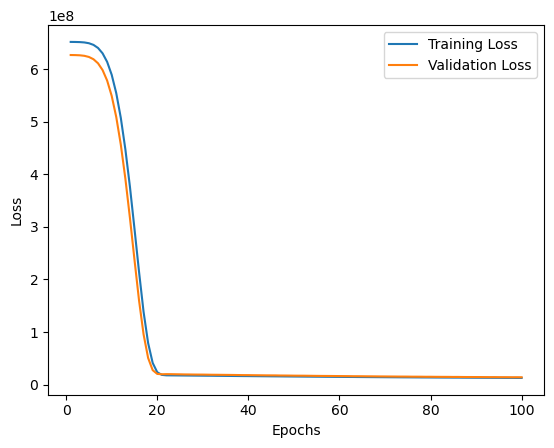

In [114]:
# Create a range of epochs
best_epoch = 100
epochs = range(1, best_epoch+1)

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions
y_pred = model.predict(X_test)